**Importing Libraries**

In [1]:
import tensorflow as tf
# this code is to allocate GPU memory for trainig execution
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

import numpy as np
import os
import time
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Defining common Parameters**: These common parameters are defined for all three methods

In [2]:
IMG_WIDTH = 150
IMG_HEIGHT = 150

BATCH_SIZE = 32
EPOCHS = 30

data_dir = './datasets/small_training'

**Images used for the comparision**:  is `Fruits 360` from `https://www.kaggle.com/moltean/fruits` Amomg the 131 categories, I have used only 14. These classes are:

`['Avocado', 'Banana', 'Blueberry', 'Cauliflower', 'Corn', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Pear', 'Pineapple', 'Pomegranate', 'Strawberry', 'Watermelon']`

Classes: ['Avocado', 'Banana', 'Blueberry', 'Cauliflower', 'Corn', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Pear', 'Pineapple', 'Pomegranate', 'Strawberry', 'Watermelon']


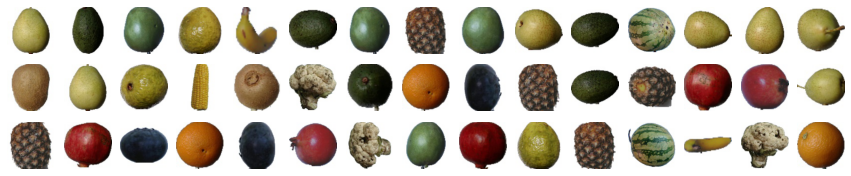

In [3]:
import glob
import random
import matplotlib.image as mpimg

print('Classes:' ,sorted([dir1 for dir1 in os.listdir(data_dir)]))

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 3
ncols = 15

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 1, nrows * 1)

for i in range(45):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(random.choice([x for x in glob.glob(data_dir+'/**/*.jpg')]))
    plt.imshow(img)

plt.show()

**Defining the optimizer, loss and accuracy**: Optimizer is same in all 3 methods. But Loss and Accuracy are common for first two methods, that are model with ImageDataGenerator and tf.Data

<span style="color:red">**NOTE** :</span>
The reason why we did not use the same `set_loss` and `set_accuracy` for Autograph, because we have to create Loss and Accuracy object separately for both training and validation

In [4]:
def set_optimizer():
    optimizer = tf.keras.optimizers.RMSprop(lr=0.0001) 
    return optimizer
def set_loss():
    loss = tf.keras.losses.CategoricalCrossentropy()  
    return loss
def set_accuracy():
    accuracy = tf.keras.metrics.CategoricalAccuracy() 
    return accuracy
optimizer = set_optimizer()
loss = set_loss()
accuracy = set_accuracy()

**Model Creation**: Model is same in all three methods. It is an `InceptionV3` model which is customizied using *functional API* to perform transfer learning.

In [5]:
# Using transfer learning for model creation
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = './tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3),
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
    layer.trainable = False 
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)    
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(len(os.listdir(data_dir)), activation='softmax')(x)           

model = tf.keras.Model(pre_trained_model.input, x)
model.summary()

last layer output shape:  (None, 7, 7, 768)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
__________________________________________________

# Model with ImageDataGenerator
To make the comparision fair, I have not used **Data Augmentation** which creating training object

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)

train_generator=train_datagen.flow_from_directory(
    data_dir,
    batch_size=BATCH_SIZE,
    seed=6,
    shuffle=True,
    class_mode="categorical",
    subset='training',
    target_size=(IMG_WIDTH, IMG_HEIGHT))

validation_generator=train_datagen.flow_from_directory(
    data_dir,
    batch_size=BATCH_SIZE,
    seed=6,
    shuffle=True,
    class_mode="categorical",
    subset='validation',
    target_size=(IMG_WIDTH, IMG_HEIGHT))

TRAINING_STEPS = len(train_generator)

Found 5521 images belonging to 14 classes.
Found 1376 images belonging to 14 classes.


**Compiling and fitting the model**:

In [7]:
model.compile(optimizer = optimizer, 
              loss = loss, 
              metrics = [accuracy])

t0 = time.time()
print('starting time: ', t0)

model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=TRAINING_STEPS,
    validation_data=validation_generator,
    verbose=1)

tn = time.time()
print('finishing time: ', tn)
t_m1 = tn - t0
print('\ntotal time taken: ', t_m1)

starting time:  1617081525.7351725
Epoch 1/30
173/173 [==============================] - 19s 76ms/step - loss: 0.5281 - categorical_accuracy: 0.8514 - val_loss: 0.0190 - val_categorical_accuracy: 0.9942
Epoch 2/30
173/173 [==============================] - 11s 62ms/step - loss: 0.0031 - categorical_accuracy: 0.9994 - val_loss: 0.0079 - val_categorical_accuracy: 0.9964
Epoch 3/30
173/173 [==============================] - 11s 62ms/step - loss: 2.7757e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0092 - val_categorical_accuracy: 0.9964
Epoch 4/30
173/173 [==============================] - 11s 63ms/step - loss: 6.3957e-04 - categorical_accuracy: 0.9998 - val_loss: 0.0076 - val_categorical_accuracy: 0.9964
Epoch 5/30
173/173 [==============================] - 11s 62ms/step - loss: 1.1156e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0029 - val_categorical_accuracy: 0.9971
Epoch 6/30
173/173 [==============================] - 11s 61ms/step - loss: 8.5571e-05 - categorical_accuracy: 1.

**Deleting the model**: To avoid running into memory errors, I have deleted the model object.

In [8]:
del model

# Model with tf.Data pipeline

In [9]:
list_ds = tf.data.Dataset.list_files(str(data_dir+'/*/*'), shuffle=False)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)

# spitting the data into training and validation datasets
val_size = int(len(list_ds) * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

class_names = np.array(sorted([dir1 for dir1 in os.listdir(data_dir)]))

print(f'Found {tf.data.experimental.cardinality(train_ds).numpy()} images belonging to {len(os.listdir(data_dir))} classes')
print(f'Found {tf.data.experimental.cardinality(val_ds).numpy()} images belonging to {len(os.listdir(data_dir))} classes')

Found 5518 images belonging to 14 classes
Found 1379 images belonging to 14 classes


In [10]:
#To process the label
def get_label(file_path):
    # convert the path to a list of path components separated by sep
    parts = tf.strings.split(file_path, os.path.sep)
  
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return one_hot

# To process the image
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

# To create the single training of validation example with image and its corresponding label
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=256)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [12]:
model = tf.keras.Model(pre_trained_model.input, x)
model.compile(optimizer = optimizer, 
              loss = loss, 
              metrics = [accuracy]) 

t0 = time.time()
print('starting time: ', t0)

history = model.fit(
    train_ds.repeat(),
    epochs=EPOCHS,
    steps_per_epoch=172,
    validation_data=val_ds,
    verbose=1)

tn = time.time()
print('finishing time: ', tn)
t_m2 = tn - t0
print('\ntotal time taken: ', t_m2)

starting time:  1617081857.4766304
Epoch 1/30
172/172 [==============================] - 15s 75ms/step - loss: 121.8257 - categorical_accuracy: 0.7419 - val_loss: 0.8376 - val_categorical_accuracy: 0.9608
Epoch 2/30
172/172 [==============================] - 11s 62ms/step - loss: 5.9450 - categorical_accuracy: 0.8500 - val_loss: 0.8086 - val_categorical_accuracy: 0.9587
Epoch 3/30
172/172 [==============================] - 11s 62ms/step - loss: 3.4387 - categorical_accuracy: 0.8954 - val_loss: 0.9850 - val_categorical_accuracy: 0.9775
Epoch 4/30
172/172 [==============================] - 11s 61ms/step - loss: 2.2590 - categorical_accuracy: 0.9277 - val_loss: 0.3899 - val_categorical_accuracy: 0.9775
Epoch 5/30
172/172 [==============================] - 11s 62ms/step - loss: 1.9118 - categorical_accuracy: 0.9315 - val_loss: 0.0956 - val_categorical_accuracy: 0.9935
Epoch 6/30
172/172 [==============================] - 11s 62ms/step - loss: 1.3187 - categorical_accuracy: 0.9469 - val_los

In [13]:
del model

# with Autograph model

In [14]:
list_ds = tf.data.Dataset.list_files(str(data_dir+'/*/*'), shuffle=False)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)

# spitting the data into training and validation datasets
val_size = int(len(list_ds) * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

class_names = np.array(sorted([dir1 for dir1 in os.listdir(data_dir)]))

print(f'Found {tf.data.experimental.cardinality(train_ds).numpy()} images belonging to {len(os.listdir(data_dir))} classes')
print(f'Found {tf.data.experimental.cardinality(val_ds).numpy()} images belonging to {len(os.listdir(data_dir))} classes')

Found 5518 images belonging to 14 classes
Found 1379 images belonging to 14 classes


In [15]:
def set_optimizer():
    optimizer = tf.keras.optimizers.RMSprop(lr=0.0001) 
    return optimizer
def set_loss():
    train_loss = tf.keras.losses.CategoricalCrossentropy() 
    val_loss = tf.keras.losses.CategoricalCrossentropy() 
    return train_loss, val_loss
def set_accuracy():
    train_accuracy = tf.keras.metrics.CategoricalAccuracy() 
    val_accuracy = tf.keras.metrics.CategoricalAccuracy() 
    return train_accuracy, val_accuracy
optimizer = set_optimizer()
train_loss, val_loss = set_loss()
train_accuracy, val_accuracy = set_accuracy()

In [16]:
@tf.function
def map_fn(img):
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
    img /= 255.0
    return img

#To process the label
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names #one-hot encoding the labels
    return one_hot

# To process the image
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return map_fn(img)

# To create the single training of validation example with image and its corresponding label
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=256)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [17]:
model = tf.keras.Model(pre_trained_model.input, x)

# selecting GPU as the training device
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'

# Custom training step
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = train_loss(y, predictions)
    grads = tape.gradient(loss, model.trainable_variables)   
    # Zip the gradients and model variables, and then apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_variables)) 
    # Call the train accuracy object on ground truth and predictions
    train_accuracy(y, predictions)
    return loss

# Decorate this function with tf.function to enable autograph on the training loop
@tf.function
def train(model, optimizer, epochs, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            # training step number increments at each iteration
            step += 1
            with tf.device(device_name=device):
                # Run one training step by passing appropriate model parameters
                # required by the function and finally get the loss to report the results
                loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)
            # Use tf.print to report your results.
            # Print the training step number, loss and accuracy
            tf.print('Step', step, 
                   ': train loss', loss, 
                   '; train accuracy', train_accuracy.result())

        with tf.device(device_name=device):
            for x, y in valid_ds:
                # Call the model on the batches of inputs x and get the predictions
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)
        
        # Print the validation loss and accuracy
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())
    
t0 = time.time()
print('starting time: ', t0)
    
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, val_ds, val_loss, val_accuracy)

tn = time.time()
print('finishing time: ', tn)
t_m3 = tn - t0
print('\ntotal time taken: ', t_m3)

starting time:  1617082607.3165264
Step 1 : train loss 2.57006311 ; train accuracy 0.03125
Step 2 : train loss 1.97808266 ; train accuracy 0.25
Step 3 : train loss 1.65106678 ; train accuracy 0.333333343
Step 4 : train loss 1.26847529 ; train accuracy 0.40625
Step 5 : train loss 0.709853172 ; train accuracy 0.5125
Step 6 : train loss 0.655120254 ; train accuracy 0.557291687
Step 7 : train loss 0.863617063 ; train accuracy 0.580357134
Step 8 : train loss 0.42618981 ; train accuracy 0.625
Step 9 : train loss 0.370180905 ; train accuracy 0.649305582
Step 10 : train loss 0.33661136 ; train accuracy 0.678125
Step 11 : train loss 0.166169614 ; train accuracy 0.707386374
Step 12 : train loss 0.437790334 ; train accuracy 0.7265625
Step 13 : train loss 0.398728669 ; train accuracy 0.737980783
Step 14 : train loss 0.113891445 ; train accuracy 0.756696403
Step 15 : train loss 0.0546099097 ; train accuracy 0.772916675
Step 16 : train loss 0.0893028 ; train accuracy 0.787109375
Step 17 : train loss

Step 131 : train loss 7.81543276e-05 ; train accuracy 0.972566783
Step 132 : train loss 9.89404944e-05 ; train accuracy 0.972774625
Step 133 : train loss 0.000328603084 ; train accuracy 0.972979307
Step 134 : train loss 0.000446135324 ; train accuracy 0.97318095
Step 135 : train loss 7.01288591e-05 ; train accuracy 0.973379612
Step 136 : train loss 0.000158887822 ; train accuracy 0.973575354
Step 137 : train loss 0.00010194839 ; train accuracy 0.973768234
Step 138 : train loss 0.000113884329 ; train accuracy 0.973958313
Step 139 : train loss 0.000136332237 ; train accuracy 0.97414571
Step 140 : train loss 7.83114447e-05 ; train accuracy 0.974330366
Step 141 : train loss 0.00010874345 ; train accuracy 0.974512398
Step 142 : train loss 0.000143837358 ; train accuracy 0.974691927
Step 143 : train loss 6.61652593e-05 ; train accuracy 0.974868894
Step 144 : train loss 6.78292781e-05 ; train accuracy 0.975043416
Step 145 : train loss 0.000194419335 ; train accuracy 0.975215495
Step 146 : tra

Step 256 : train loss 6.81727329e-07 ; train accuracy 0.985931
Step 257 : train loss 4.55207737e-06 ; train accuracy 0.985985875
Step 258 : train loss 3.23351719e-06 ; train accuracy 0.986040294
Step 259 : train loss 8.23288303e-07 ; train accuracy 0.986094296
Step 260 : train loss 1.15856233e-06 ; train accuracy 0.98614794
Step 261 : train loss 1.16228875e-06 ; train accuracy 0.986201108
Step 262 : train loss 8.60540183e-07 ; train accuracy 0.986253858
Step 263 : train loss 1.15856085e-06 ; train accuracy 0.98630625
Step 264 : train loss 8.30738543e-07 ; train accuracy 0.986358225
Step 265 : train loss 9.23870687e-07 ; train accuracy 0.986409843
Step 266 : train loss 1.65402139e-06 ; train accuracy 0.986461043
Step 267 : train loss 1.07660333e-06 ; train accuracy 0.986511827
Step 268 : train loss 1.0132751e-06 ; train accuracy 0.986562252
Step 269 : train loss 6.0349646e-07 ; train accuracy 0.98661232
Step 270 : train loss 5.550678e-07 ; train accuracy 0.98666203
Step 271 : train loss

Step 381 : train loss 1.04308086e-07 ; train accuracy 0.99053967
Step 382 : train loss 1.60187398e-07 ; train accuracy 0.990564466
Step 383 : train loss 7.82310821e-08 ; train accuracy 0.990589201
Step 384 : train loss 7.45057918e-08 ; train accuracy 0.990613759
Step 385 : train loss 3.72529e-08 ; train accuracy 0.990638256
Step 386 : train loss 2.60770303e-08 ; train accuracy 0.990662575
Step 387 : train loss 1.93714982e-07 ; train accuracy 0.990686774
Step 388 : train loss 3.35276091e-08 ; train accuracy 0.990710795
Step 389 : train loss 5.58793403e-08 ; train accuracy 0.990734756
Step 390 : train loss 8.94069103e-08 ; train accuracy 0.990758598
Step 391 : train loss 1.04308107e-07 ; train accuracy 0.99078232
Step 392 : train loss 5.21540571e-08 ; train accuracy 0.990805864
Step 393 : train loss 1.7508853e-07 ; train accuracy 0.990829349
Step 394 : train loss 4.47034765e-08 ; train accuracy 0.990852714
Step 395 : train loss 9.31322433e-08 ; train accuracy 0.9908759
Step 396 : train l

Step 507 : train loss 4.47034765e-08 ; train accuracy 0.992895961
Step 508 : train loss 1.30385118e-07 ; train accuracy 0.992909968
Step 509 : train loss 3.35276091e-08 ; train accuracy 0.992924
Step 510 : train loss 1.86264497e-08 ; train accuracy 0.992937863
Step 511 : train loss 2.98023188e-08 ; train accuracy 0.992951691
Step 512 : train loss 5.96046164e-08 ; train accuracy 0.992965519
Step 513 : train loss 6.3329928e-08 ; train accuracy 0.992979228
Step 514 : train loss 7.07804659e-08 ; train accuracy 0.992992938
Step 515 : train loss 1.117587e-08 ; train accuracy 0.993006587
Step 516 : train loss 3.35276056e-08 ; train accuracy 0.993020177
Step 517 : train loss 9.31321864e-08 ; train accuracy 0.993033707
Step 518 : train loss 7.45058e-09 ; train accuracy 0.993047178
Step 519 : train loss 1.70298975e-08 ; train accuracy 0.993053
val loss 3.97364275e-08 ; val accuracy 1
Step 520 : train loss 1.117587e-08 ; train accuracy 0.99306643
Step 521 : train loss 2.235174e-08 ; train accurac

Step 633 : train loss 2.60770285e-08 ; train accuracy 0.994307518
Step 634 : train loss 1.49011594e-08 ; train accuracy 0.994316518
Step 635 : train loss 1.117587e-08 ; train accuracy 0.994325459
Step 636 : train loss 3.35276091e-08 ; train accuracy 0.9943344
Step 637 : train loss 2.235174e-08 ; train accuracy 0.99434334
Step 638 : train loss 3.72529e-09 ; train accuracy 0.994352221
Step 639 : train loss 2.98023188e-08 ; train accuracy 0.994361103
Step 640 : train loss 2.23517382e-08 ; train accuracy 0.994369924
Step 641 : train loss 2.98023188e-08 ; train accuracy 0.994378746
Step 642 : train loss 5.58793225e-08 ; train accuracy 0.994387507
Step 643 : train loss 3.72529e-09 ; train accuracy 0.994396269
Step 644 : train loss 2.60770285e-08 ; train accuracy 0.994405
Step 645 : train loss 2.235174e-08 ; train accuracy 0.994413674
Step 646 : train loss 1.117587e-08 ; train accuracy 0.994422376
Step 647 : train loss 2.60770303e-08 ; train accuracy 0.994431
Step 648 : train loss 1.49011594e

Step 760 : train loss 1.86264497e-08 ; train accuracy 0.995257318
Step 761 : train loss 5.21540571e-08 ; train accuracy 0.995263577
Step 762 : train loss 7.45057971e-09 ; train accuracy 0.995269835
Step 763 : train loss 1.86264497e-08 ; train accuracy 0.995276034
Step 764 : train loss 1.86264497e-08 ; train accuracy 0.995282233
Step 765 : train loss 2.98023188e-08 ; train accuracy 0.995288432
Step 766 : train loss 2.60770285e-08 ; train accuracy 0.995294571
Step 767 : train loss 5.96046128e-08 ; train accuracy 0.99530077
Step 768 : train loss 1.86264497e-08 ; train accuracy 0.995306909
Step 769 : train loss 3.72529e-09 ; train accuracy 0.995313
Step 770 : train loss 3.72529e-09 ; train accuracy 0.995319128
Step 771 : train loss 1.117587e-08 ; train accuracy 0.995325208
Step 772 : train loss 2.235174e-08 ; train accuracy 0.995331287
Step 773 : train loss 1.49011603e-08 ; train accuracy 0.995337307
Step 774 : train loss 1.117587e-08 ; train accuracy 0.995343387
Step 775 : train loss 1.11

Step 887 : train loss 5.9604627e-08 ; train accuracy 0.995935559
Step 888 : train loss 1.49011603e-08 ; train accuracy 0.995940149
Step 889 : train loss 1.49011603e-08 ; train accuracy 0.995944679
Step 890 : train loss 3.72529e-09 ; train accuracy 0.995949268
Step 891 : train loss 0 ; train accuracy 0.995953858
Step 892 : train loss 1.86264497e-08 ; train accuracy 0.995958388
Step 893 : train loss 3.72529e-09 ; train accuracy 0.995962918
Step 894 : train loss 2.235174e-08 ; train accuracy 0.995967448
Step 895 : train loss 3.72529e-09 ; train accuracy 0.995972
Step 896 : train loss 1.49011594e-08 ; train accuracy 0.995976508
Step 897 : train loss 7.45058e-09 ; train accuracy 0.995981
Step 898 : train loss 1.86264462e-08 ; train accuracy 0.995985448
Step 899 : train loss 1.49011603e-08 ; train accuracy 0.99599
Step 900 : train loss 2.23517382e-08 ; train accuracy 0.995994449
Step 901 : train loss 0 ; train accuracy 0.995998859
Step 902 : train loss 3.72529e-09 ; train accuracy 0.99600333

Step 1016 : train loss 1.86264497e-08 ; train accuracy 0.996453047
Step 1017 : train loss 1.86264497e-08 ; train accuracy 0.996456504
Step 1018 : train loss 1.117587e-08 ; train accuracy 0.99646
Step 1019 : train loss 1.86264497e-08 ; train accuracy 0.996463478
Step 1020 : train loss 7.45058e-09 ; train accuracy 0.996467
Step 1021 : train loss 1.49011603e-08 ; train accuracy 0.996470451
Step 1022 : train loss 7.07804944e-08 ; train accuracy 0.996473908
Step 1023 : train loss 5.21540429e-08 ; train accuracy 0.996477365
Step 1024 : train loss 7.45058e-09 ; train accuracy 0.996480823
Step 1025 : train loss 1.117587e-08 ; train accuracy 0.99648428
Step 1026 : train loss 4.09781826e-08 ; train accuracy 0.996487677
Step 1027 : train loss 2.23517382e-08 ; train accuracy 0.996491134
Step 1028 : train loss 1.86264497e-08 ; train accuracy 0.996494532
Step 1029 : train loss 1.86264497e-08 ; train accuracy 0.996498
Step 1030 : train loss 3.35276091e-08 ; train accuracy 0.996501386
Step 1031 : trai

Step 1143 : train loss 1.86264497e-08 ; train accuracy 0.996846557
Step 1144 : train loss 1.117587e-08 ; train accuracy 0.996849298
Step 1145 : train loss 3.72529e-09 ; train accuracy 0.9968521
Step 1146 : train loss 1.117587e-08 ; train accuracy 0.996854842
Step 1147 : train loss 0 ; train accuracy 0.996857584
Step 1148 : train loss 1.49011603e-08 ; train accuracy 0.996860325
Step 1149 : train loss 1.117587e-08 ; train accuracy 0.996863067
Step 1150 : train loss 3.72529e-09 ; train accuracy 0.996865809
Step 1151 : train loss 1.86264497e-08 ; train accuracy 0.996868551
Step 1152 : train loss 2.60770303e-08 ; train accuracy 0.996871233
Step 1153 : train loss 1.86264497e-08 ; train accuracy 0.996874
Step 1154 : train loss 4.09781897e-08 ; train accuracy 0.996876717
Step 1155 : train loss 1.117587e-08 ; train accuracy 0.996879399
Step 1156 : train loss 0 ; train accuracy 0.996882141
Step 1157 : train loss 3.35276e-08 ; train accuracy 0.996884823
Step 1158 : train loss 7.45058e-09 ; train 

Step 1271 : train loss 1.117587e-08 ; train accuracy 0.997163713
Step 1272 : train loss 1.117587e-08 ; train accuracy 0.997166
Step 1273 : train loss 1.117587e-08 ; train accuracy 0.997168183
Step 1274 : train loss 1.86264479e-08 ; train accuracy 0.997170389
Step 1275 : train loss 7.45058e-09 ; train accuracy 0.997172654
Step 1276 : train loss 2.60770268e-08 ; train accuracy 0.997174859
Step 1277 : train loss 1.117587e-08 ; train accuracy 0.997177064
Step 1278 : train loss 3.72529e-09 ; train accuracy 0.99717927
Step 1279 : train loss 0 ; train accuracy 0.997181535
Step 1280 : train loss 3.72529e-09 ; train accuracy 0.99718374
Step 1281 : train loss 0 ; train accuracy 0.997185946
Step 1282 : train loss 1.49011594e-08 ; train accuracy 0.997188151
Step 1283 : train loss 3.72529e-09 ; train accuracy 0.997190297
Step 1284 : train loss 7.45058e-09 ; train accuracy 0.997192502
Step 1285 : train loss 4.09781791e-08 ; train accuracy 0.997194707
Step 1286 : train loss 3.72529e-09 ; train accura

Step 1399 : train loss 4.09781791e-08 ; train accuracy 0.997422934
Step 1400 : train loss 1.49011603e-08 ; train accuracy 0.997424781
Step 1401 : train loss 2.60770268e-08 ; train accuracy 0.997426629
Step 1402 : train loss 1.117587e-08 ; train accuracy 0.997428417
Step 1403 : train loss 1.49011603e-08 ; train accuracy 0.997430265
Step 1404 : train loss 7.45058e-09 ; train accuracy 0.997432113
Step 1405 : train loss 1.117587e-08 ; train accuracy 0.99743396
Step 1406 : train loss 0 ; train accuracy 0.997435808
Step 1407 : train loss 1.86264479e-08 ; train accuracy 0.997437596
Step 1408 : train loss 0 ; train accuracy 0.997439444
Step 1409 : train loss 2.235174e-08 ; train accuracy 0.997441232
Step 1410 : train loss 0 ; train accuracy 0.99744308
Step 1411 : train loss 7.45058e-09 ; train accuracy 0.997444928
Step 1412 : train loss 0 ; train accuracy 0.997446716
Step 1413 : train loss 1.117587e-08 ; train accuracy 0.997448504
Step 1414 : train loss 1.86264479e-08 ; train accuracy 0.997450

Step 1529 : train loss 7.45058e-09 ; train accuracy 0.997642696
Step 1530 : train loss 3.72529e-09 ; train accuracy 0.997644186
Step 1531 : train loss 1.117587e-08 ; train accuracy 0.997645736
Step 1532 : train loss 1.11758691e-08 ; train accuracy 0.997647285
Step 1533 : train loss 3.72529e-09 ; train accuracy 0.997648835
Step 1534 : train loss 2.235174e-08 ; train accuracy 0.997650385
Step 1535 : train loss 4.47034729e-08 ; train accuracy 0.997651935
Step 1536 : train loss 2.235174e-08 ; train accuracy 0.997653425
Step 1537 : train loss 7.45058e-09 ; train accuracy 0.997655
Step 1538 : train loss 3.35276091e-08 ; train accuracy 0.997656524
Step 1539 : train loss 1.117587e-08 ; train accuracy 0.997658
Step 1540 : train loss 7.45058e-09 ; train accuracy 0.997659564
Step 1541 : train loss 2.6077025e-08 ; train accuracy 0.997661054
Step 1542 : train loss 2.23517382e-08 ; train accuracy 0.997662604
Step 1543 : train loss 7.45058e-09 ; train accuracy 0.997664094
Step 1544 : train loss 1.117

Step 1658 : train loss 1.117587e-08 ; train accuracy 0.997825861
Step 1659 : train loss 0 ; train accuracy 0.997827172
Step 1660 : train loss 3.72529e-09 ; train accuracy 0.997828484
Step 1661 : train loss 3.72529e-09 ; train accuracy 0.997829795
Step 1662 : train loss 3.72529e-09 ; train accuracy 0.997831106
Step 1663 : train loss 3.72529e-09 ; train accuracy 0.997832417
Step 1664 : train loss 0 ; train accuracy 0.997833729
Step 1665 : train loss 3.72529e-09 ; train accuracy 0.997835
Step 1666 : train loss 2.235174e-08 ; train accuracy 0.997836292
Step 1667 : train loss 3.72529e-09 ; train accuracy 0.997837603
Step 1668 : train loss 3.72529e-09 ; train accuracy 0.997838914
Step 1669 : train loss 1.49011603e-08 ; train accuracy 0.997840226
Step 1670 : train loss 1.49011594e-08 ; train accuracy 0.997841537
Step 1671 : train loss 3.72529e-09 ; train accuracy 0.997842789
Step 1672 : train loss 1.117587e-08 ; train accuracy 0.9978441
Step 1673 : train loss 7.45057971e-09 ; train accuracy 0

Step 1787 : train loss 0 ; train accuracy 0.997982621
Step 1788 : train loss 7.45057971e-09 ; train accuracy 0.997983754
Step 1789 : train loss 3.72529e-09 ; train accuracy 0.997984886
Step 1790 : train loss 1.117587e-08 ; train accuracy 0.997986
Step 1791 : train loss 1.49011603e-08 ; train accuracy 0.997987092
Step 1792 : train loss 0 ; train accuracy 0.997988224
Step 1793 : train loss 7.45058e-09 ; train accuracy 0.997989357
Step 1794 : train loss 2.98023171e-08 ; train accuracy 0.997990489
Step 1795 : train loss 3.35276056e-08 ; train accuracy 0.997991621
Step 1796 : train loss 0 ; train accuracy 0.997992754
Step 1797 : train loss 1.86264497e-08 ; train accuracy 0.997993886
Step 1798 : train loss 1.117587e-08 ; train accuracy 0.997994959
Step 1799 : train loss 7.45058e-09 ; train accuracy 0.997996092
Step 1800 : train loss 1.49011576e-08 ; train accuracy 0.997997224
Step 1801 : train loss 3.72529e-09 ; train accuracy 0.997998357
Step 1802 : train loss 1.49011594e-08 ; train accurac

Step 1916 : train loss 7.45058e-09 ; train accuracy 0.998118281
Step 1917 : train loss 3.72529e-09 ; train accuracy 0.998119235
Step 1918 : train loss 0 ; train accuracy 0.998120248
Step 1919 : train loss 7.45057971e-09 ; train accuracy 0.998121202
Step 1920 : train loss 3.72529e-09 ; train accuracy 0.998122215
Step 1921 : train loss 3.72529e-09 ; train accuracy 0.998123169
Step 1922 : train loss 2.235174e-08 ; train accuracy 0.998124182
Step 1923 : train loss 3.72529e-09 ; train accuracy 0.998125136
Step 1924 : train loss 1.49011603e-08 ; train accuracy 0.998126149
Step 1925 : train loss 1.49011594e-08 ; train accuracy 0.998127103
Step 1926 : train loss 1.11758691e-08 ; train accuracy 0.998128057
Step 1927 : train loss 2.23517365e-08 ; train accuracy 0.99812907
Step 1928 : train loss 7.45058e-09 ; train accuracy 0.99813
Step 1929 : train loss 7.45057971e-09 ; train accuracy 0.998131
Step 1930 : train loss 0 ; train accuracy 0.998132
Step 1931 : train loss 1.117587e-08 ; train accuracy

Step 2046 : train loss 7.45058e-09 ; train accuracy 0.998238206
Step 2047 : train loss 1.49011603e-08 ; train accuracy 0.99823904
Step 2048 : train loss 3.3527602e-08 ; train accuracy 0.998239934
Step 2049 : train loss 0 ; train accuracy 0.998240769
Step 2050 : train loss 3.72529e-09 ; train accuracy 0.998241663
Step 2051 : train loss 3.72529e-09 ; train accuracy 0.998242497
Step 2052 : train loss 1.49011603e-08 ; train accuracy 0.998243392
Step 2053 : train loss 1.117587e-08 ; train accuracy 0.998244226
Step 2054 : train loss 1.49011603e-08 ; train accuracy 0.99824506
Step 2055 : train loss 1.117587e-08 ; train accuracy 0.998245955
Step 2056 : train loss 1.117587e-08 ; train accuracy 0.998246789
Step 2057 : train loss 1.49011603e-08 ; train accuracy 0.998247623
Step 2058 : train loss 1.86264497e-08 ; train accuracy 0.998248518
Step 2059 : train loss 7.45058e-09 ; train accuracy 0.998249352
Step 2060 : train loss 3.72529e-09 ; train accuracy 0.998250186
Step 2061 : train loss 1.117587e

Step 2175 : train loss 7.45058e-09 ; train accuracy 0.998342574
Step 2176 : train loss 1.117587e-08 ; train accuracy 0.998343349
Step 2177 : train loss 7.45058e-09 ; train accuracy 0.998344064
Step 2178 : train loss 0 ; train accuracy 0.998344839
Step 2179 : train loss 0 ; train accuracy 0.998345613
Step 2180 : train loss 0 ; train accuracy 0.998346388
Step 2181 : train loss 3.72529e-09 ; train accuracy 0.998347104
Step 2182 : train loss 3.72529e-09 ; train accuracy 0.998347878
Step 2183 : train loss 7.45058e-09 ; train accuracy 0.998348653
Step 2184 : train loss 1.86264497e-08 ; train accuracy 0.998349428
Step 2185 : train loss 0 ; train accuracy 0.998350143
Step 2186 : train loss 3.72529e-09 ; train accuracy 0.998350918
Step 2187 : train loss 1.117587e-08 ; train accuracy 0.998351693
Step 2188 : train loss 3.72529e-09 ; train accuracy 0.998352408
Step 2189 : train loss 7.45058e-09 ; train accuracy 0.998353183
Step 2190 : train loss 1.117587e-08 ; train accuracy 0.998353958
Step 2191 

Step 2305 : train loss 7.45058e-09 ; train accuracy 0.998435915
Step 2306 : train loss 7.45058e-09 ; train accuracy 0.99843663
Step 2307 : train loss 7.45058e-09 ; train accuracy 0.998437285
Step 2308 : train loss 3.72529e-09 ; train accuracy 0.998437941
Step 2309 : train loss 2.23517382e-08 ; train accuracy 0.998438656
Step 2310 : train loss 2.23517382e-08 ; train accuracy 0.998439312
Step 2311 : train loss 1.117587e-08 ; train accuracy 0.99844
Step 2312 : train loss 1.117587e-08 ; train accuracy 0.998440683
Step 2313 : train loss 7.45057971e-09 ; train accuracy 0.998441339
Step 2314 : train loss 7.45058e-09 ; train accuracy 0.998442054
Step 2315 : train loss 3.72529e-09 ; train accuracy 0.998442709
Step 2316 : train loss 1.86264497e-08 ; train accuracy 0.998443365
Step 2317 : train loss 7.45058e-09 ; train accuracy 0.99844408
Step 2318 : train loss 0 ; train accuracy 0.998444736
Step 2319 : train loss 3.72529e-09 ; train accuracy 0.998445392
Step 2320 : train loss 1.49011603e-08 ; tr

Step 2434 : train loss 0 ; train accuracy 0.998518705
Step 2435 : train loss 1.117587e-08 ; train accuracy 0.998519361
Step 2436 : train loss 3.72529e-09 ; train accuracy 0.998519957
Step 2437 : train loss 1.49011594e-08 ; train accuracy 0.998520553
Step 2438 : train loss 1.49011594e-08 ; train accuracy 0.998521149
Step 2439 : train loss 7.45058e-09 ; train accuracy 0.998521745
Step 2440 : train loss 1.49011603e-08 ; train accuracy 0.998522401
Step 2441 : train loss 1.117587e-08 ; train accuracy 0.998523
Step 2442 : train loss 0 ; train accuracy 0.998523593
Step 2443 : train loss 0 ; train accuracy 0.998524189
Step 2444 : train loss 1.86264479e-08 ; train accuracy 0.998524785
Step 2445 : train loss 0 ; train accuracy 0.998525441
Step 2446 : train loss 0 ; train accuracy 0.998526037
Step 2447 : train loss 0 ; train accuracy 0.998526633
Step 2448 : train loss 3.72529e-09 ; train accuracy 0.998527229
Step 2449 : train loss 7.45057971e-09 ; train accuracy 0.998527825
Step 2450 : train loss

Step 2565 : train loss 1.117587e-08 ; train accuracy 0.998594642
Step 2566 : train loss 3.72529e-09 ; train accuracy 0.998595178
Step 2567 : train loss 3.72529e-09 ; train accuracy 0.998595715
Step 2568 : train loss 2.98023188e-08 ; train accuracy 0.998596251
Step 2569 : train loss 1.49011594e-08 ; train accuracy 0.998596787
Step 2570 : train loss 3.72529e-09 ; train accuracy 0.998597383
Step 2571 : train loss 0 ; train accuracy 0.99859792
Step 2572 : train loss 0 ; train accuracy 0.998598456
Step 2573 : train loss 7.45058e-09 ; train accuracy 0.998599
Step 2574 : train loss 2.235174e-08 ; train accuracy 0.998599529
Step 2575 : train loss 7.45058e-09 ; train accuracy 0.998600066
Step 2576 : train loss 3.72529e-09 ; train accuracy 0.998600662
Step 2577 : train loss 2.6077025e-08 ; train accuracy 0.998601198
Step 2578 : train loss 3.72529e-09 ; train accuracy 0.998601735
Step 2579 : train loss 7.45058e-09 ; train accuracy 0.998602271
Step 2580 : train loss 7.45058e-09 ; train accuracy 0.

Step 2694 : train loss 0 ; train accuracy 0.998661816
Step 2695 : train loss 1.11758691e-08 ; train accuracy 0.998662353
Step 2696 : train loss 1.49011603e-08 ; train accuracy 0.998662829
Step 2697 : train loss 7.45057971e-09 ; train accuracy 0.998663306
Step 2698 : train loss 7.45058e-09 ; train accuracy 0.998663843
Step 2699 : train loss 7.45057971e-09 ; train accuracy 0.99866432
Step 2700 : train loss 1.86264497e-08 ; train accuracy 0.998664796
Step 2701 : train loss 0 ; train accuracy 0.998665333
Step 2702 : train loss 3.72529e-09 ; train accuracy 0.99866581
Step 2703 : train loss 3.72529e-09 ; train accuracy 0.998666286
Step 2704 : train loss 7.45058e-09 ; train accuracy 0.998666763
Step 2705 : train loss 3.72529e-09 ; train accuracy 0.9986673
Step 2706 : train loss 0 ; train accuracy 0.998667777
Step 2707 : train loss 1.11758691e-08 ; train accuracy 0.998668253
Step 2708 : train loss 1.117587e-08 ; train accuracy 0.99866879
Step 2709 : train loss 3.72529e-09 ; train accuracy 0.99

Step 2825 : train loss 7.45057971e-09 ; train accuracy 0.998723805
Step 2826 : train loss 0 ; train accuracy 0.998724282
Step 2827 : train loss 1.49011594e-08 ; train accuracy 0.998724699
Step 2828 : train loss 3.72529e-09 ; train accuracy 0.998725176
Step 2829 : train loss 2.23517382e-08 ; train accuracy 0.998725593
Step 2830 : train loss 7.45058e-09 ; train accuracy 0.99872607
Step 2831 : train loss 7.45058e-09 ; train accuracy 0.998726547
Step 2832 : train loss 0 ; train accuracy 0.998726964
Step 2833 : train loss 3.72529e-09 ; train accuracy 0.998727441
Step 2834 : train loss 1.49011594e-08 ; train accuracy 0.998727858
Step 2835 : train loss 2.23517382e-08 ; train accuracy 0.998728335
Step 2836 : train loss 0 ; train accuracy 0.998728752
Step 2837 : train loss 7.45058e-09 ; train accuracy 0.998729229
Step 2838 : train loss 1.49011603e-08 ; train accuracy 0.998729646
Step 2839 : train loss 1.49011594e-08 ; train accuracy 0.998730123
Step 2840 : train loss 3.72529e-09 ; train accurac

Step 2956 : train loss 1.117587e-08 ; train accuracy 0.99878031
Step 2957 : train loss 0 ; train accuracy 0.998780727
Step 2958 : train loss 7.45058e-09 ; train accuracy 0.998781145
Step 2959 : train loss 3.72529e-09 ; train accuracy 0.998781562
Step 2960 : train loss 0 ; train accuracy 0.998782
Step 2961 : train loss 1.11758691e-08 ; train accuracy 0.998782396
Step 2962 : train loss 1.117587e-08 ; train accuracy 0.998782814
Step 2963 : train loss 1.117587e-08 ; train accuracy 0.998783171
Step 2964 : train loss 7.45057971e-09 ; train accuracy 0.998783588
Step 2965 : train loss 7.45058e-09 ; train accuracy 0.998784
Step 2966 : train loss 7.45058e-09 ; train accuracy 0.998784423
Step 2967 : train loss 0 ; train accuracy 0.99878484
Step 2968 : train loss 0 ; train accuracy 0.998785257
Step 2969 : train loss 3.72529e-09 ; train accuracy 0.998785675
Step 2970 : train loss 3.72529e-09 ; train accuracy 0.998786092
Step 2971 : train loss 7.45057971e-09 ; train accuracy 0.998786509
Step 2972 : 

Step 3088 : train loss 1.86264497e-08 ; train accuracy 0.998832583
Step 3089 : train loss 2.60770285e-08 ; train accuracy 0.998833
Step 3090 : train loss 1.117587e-08 ; train accuracy 0.998833358
Step 3091 : train loss 0 ; train accuracy 0.998833716
Step 3092 : train loss 3.72529e-09 ; train accuracy 0.998834133
Step 3093 : train loss 7.45058e-09 ; train accuracy 0.998834491
Step 3094 : train loss 3.72529e-09 ; train accuracy 0.998834848
Step 3095 : train loss 1.86264497e-08 ; train accuracy 0.998835266
Step 3096 : train loss 1.86264497e-08 ; train accuracy 0.998835623
Step 3097 : train loss 1.117587e-08 ; train accuracy 0.998836
Step 3098 : train loss 7.45058e-09 ; train accuracy 0.998836398
Step 3099 : train loss 7.45058e-09 ; train accuracy 0.998836756
Step 3100 : train loss 1.49011603e-08 ; train accuracy 0.998837113
Step 3101 : train loss 1.49011576e-08 ; train accuracy 0.998837531
Step 3102 : train loss 1.86264497e-08 ; train accuracy 0.998837888
Step 3103 : train loss 3.72529e-0

Step 3220 : train loss 0 ; train accuracy 0.998880386
Step 3221 : train loss 7.45057971e-09 ; train accuracy 0.998880744
Step 3222 : train loss 0 ; train accuracy 0.998881102
Step 3223 : train loss 3.72529e-09 ; train accuracy 0.998881459
Step 3224 : train loss 3.72529e-09 ; train accuracy 0.998881817
Step 3225 : train loss 3.72529e-09 ; train accuracy 0.998882174
Step 3226 : train loss 0 ; train accuracy 0.998882473
Step 3227 : train loss 7.45058e-09 ; train accuracy 0.99888283
Step 3228 : train loss 7.45058e-09 ; train accuracy 0.998883188
Step 3229 : train loss 3.72529e-09 ; train accuracy 0.998883545
Step 3230 : train loss 1.117587e-08 ; train accuracy 0.998883903
Step 3231 : train loss 3.72529e-09 ; train accuracy 0.998884261
Step 3232 : train loss 1.86264497e-08 ; train accuracy 0.998884559
Step 3233 : train loss 7.45058e-09 ; train accuracy 0.998884916
Step 3234 : train loss 1.49011576e-08 ; train accuracy 0.998885274
Step 3235 : train loss 1.117587e-08 ; train accuracy 0.998885

Step 3351 : train loss 1.86264497e-08 ; train accuracy 0.998924136
Step 3352 : train loss 3.72529e-09 ; train accuracy 0.998924434
Step 3353 : train loss 0 ; train accuracy 0.998924792
Step 3354 : train loss 7.45057971e-09 ; train accuracy 0.99892509
Step 3355 : train loss 1.49011603e-08 ; train accuracy 0.998925388
Step 3356 : train loss 1.86264479e-08 ; train accuracy 0.998925745
Step 3357 : train loss 7.45058e-09 ; train accuracy 0.998926044
Step 3358 : train loss 7.45058e-09 ; train accuracy 0.998926401
Step 3359 : train loss 7.45058e-09 ; train accuracy 0.998926699
Step 3360 : train loss 7.45058e-09 ; train accuracy 0.998927
Step 3361 : train loss 0 ; train accuracy 0.998927355
Step 3362 : train loss 0 ; train accuracy 0.998927653
Step 3363 : train loss 3.72529e-09 ; train accuracy 0.998927951
Step 3364 : train loss 3.72529e-09 ; train accuracy 0.998928308
Step 3365 : train loss 0 ; train accuracy 0.998928607
Step 3366 : train loss 2.60770303e-08 ; train accuracy 0.998928964
Step 

Step 3482 : train loss 3.72529e-09 ; train accuracy 0.998964548
Step 3483 : train loss 7.45058e-09 ; train accuracy 0.998964846
Step 3484 : train loss 3.72529e-09 ; train accuracy 0.998965144
Step 3485 : train loss 0 ; train accuracy 0.998965442
Step 3486 : train loss 3.72529e-09 ; train accuracy 0.99896574
Step 3487 : train loss 0 ; train accuracy 0.998966038
Step 3488 : train loss 0 ; train accuracy 0.998966336
Step 3489 : train loss 0 ; train accuracy 0.998966634
Step 3490 : train loss 1.49011594e-08 ; train accuracy 0.998966932
Step 3491 : train loss 3.72529e-09 ; train accuracy 0.99896723
Step 3492 : train loss 3.72529e-09 ; train accuracy 0.998967528
Step 3493 : train loss 7.45058e-09 ; train accuracy 0.998967826
Step 3494 : train loss 3.72529e-09 ; train accuracy 0.998968124
Step 3495 : train loss 0 ; train accuracy 0.998968422
Step 3496 : train loss 1.11758691e-08 ; train accuracy 0.99896872
Step 3497 : train loss 0 ; train accuracy 0.998969
Step 3498 : train loss 7.45058e-09 ;

Step 3615 : train loss 2.60770303e-08 ; train accuracy 0.999002755
Step 3616 : train loss 3.72529e-09 ; train accuracy 0.999003053
Step 3617 : train loss 1.117587e-08 ; train accuracy 0.999003351
Step 3618 : train loss 2.98023188e-08 ; train accuracy 0.999003589
Step 3619 : train loss 1.49011603e-08 ; train accuracy 0.999003887
Step 3620 : train loss 2.235174e-08 ; train accuracy 0.999004185
Step 3621 : train loss 3.72529e-09 ; train accuracy 0.999004424
Step 3622 : train loss 3.72529e-09 ; train accuracy 0.999004722
Step 3623 : train loss 1.49011603e-08 ; train accuracy 0.99900496
Step 3624 : train loss 3.72529e-09 ; train accuracy 0.999005258
Step 3625 : train loss 3.72529e-09 ; train accuracy 0.999005556
Step 3626 : train loss 7.45058e-09 ; train accuracy 0.999005795
Step 3627 : train loss 0 ; train accuracy 0.999006093
Step 3628 : train loss 1.117587e-08 ; train accuracy 0.999006331
Step 3629 : train loss 3.72529e-09 ; train accuracy 0.999006629
Step 3630 : train loss 1.49011603e-0

Step 3747 : train loss 1.117587e-08 ; train accuracy 0.999037862
Step 3748 : train loss 7.45058e-09 ; train accuracy 0.9990381
Step 3749 : train loss 3.72529e-09 ; train accuracy 0.999038398
Step 3750 : train loss 0 ; train accuracy 0.999038637
Step 3751 : train loss 1.117587e-08 ; train accuracy 0.999038875
Step 3752 : train loss 0 ; train accuracy 0.999039173
Step 3753 : train loss 7.45058e-09 ; train accuracy 0.999039412
Step 3754 : train loss 7.45058e-09 ; train accuracy 0.99903965
Step 3755 : train loss 3.72529e-09 ; train accuracy 0.999039948
Step 3756 : train loss 3.72529e-09 ; train accuracy 0.999040186
Step 3757 : train loss 1.117587e-08 ; train accuracy 0.999040425
Step 3758 : train loss 3.72529e-09 ; train accuracy 0.999040663
Step 3759 : train loss 2.235174e-08 ; train accuracy 0.999040961
Step 3760 : train loss 0 ; train accuracy 0.9990412
Step 3761 : train loss 3.72529e-09 ; train accuracy 0.999041438
Step 3762 : train loss 0 ; train accuracy 0.999041736
Step 3763 : train

Step 3878 : train loss 0 ; train accuracy 0.999070346
Step 3879 : train loss 1.117587e-08 ; train accuracy 0.999070585
Step 3880 : train loss 7.45058e-09 ; train accuracy 0.999070823
Step 3881 : train loss 3.72529e-09 ; train accuracy 0.999071062
Step 3882 : train loss 1.11758691e-08 ; train accuracy 0.9990713
Step 3883 : train loss 7.45058e-09 ; train accuracy 0.999071538
Step 3884 : train loss 1.117587e-08 ; train accuracy 0.999071777
Step 3885 : train loss 1.49011576e-08 ; train accuracy 0.999072
Step 3886 : train loss 3.72529e-09 ; train accuracy 0.999072254
Step 3887 : train loss 3.72529e-09 ; train accuracy 0.999072492
Step 3888 : train loss 7.45058e-09 ; train accuracy 0.999072731
Step 3889 : train loss 3.72529e-09 ; train accuracy 0.999072969
Step 3890 : train loss 3.72529e-09 ; train accuracy 0.999073207
Step 3891 : train loss 0 ; train accuracy 0.999073446
Step 3892 : train loss 0 ; train accuracy 0.999073684
Step 3893 : train loss 3.72529e-09 ; train accuracy 0.999073923
Ste

Step 4010 : train loss 3.72529e-09 ; train accuracy 0.999100924
Step 4011 : train loss 0 ; train accuracy 0.999101102
Step 4012 : train loss 1.86264497e-08 ; train accuracy 0.999101341
Step 4013 : train loss 0 ; train accuracy 0.999101579
Step 4014 : train loss 0 ; train accuracy 0.999101818
Step 4015 : train loss 3.72529e-09 ; train accuracy 0.999102
Step 4016 : train loss 7.45058e-09 ; train accuracy 0.999102235
Step 4017 : train loss 3.72529e-09 ; train accuracy 0.999102473
Step 4018 : train loss 3.72529e-09 ; train accuracy 0.999102712
Step 4019 : train loss 3.72529e-09 ; train accuracy 0.99910295
Step 4020 : train loss 3.72529e-09 ; train accuracy 0.999103129
Step 4021 : train loss 0 ; train accuracy 0.999103367
Step 4022 : train loss 1.117587e-08 ; train accuracy 0.999103606
Step 4023 : train loss 1.117587e-08 ; train accuracy 0.999103844
Step 4024 : train loss 0 ; train accuracy 0.999104
Step 4025 : train loss 1.117587e-08 ; train accuracy 0.999104261
Step 4026 : train loss 3.72

Step 4143 : train loss 7.45057971e-09 ; train accuracy 0.999129832
Step 4144 : train loss 1.49011603e-08 ; train accuracy 0.99913007
Step 4145 : train loss 1.117587e-08 ; train accuracy 0.999130249
Step 4146 : train loss 7.45058e-09 ; train accuracy 0.999130487
Step 4147 : train loss 0 ; train accuracy 0.999130726
Step 4148 : train loss 7.45058e-09 ; train accuracy 0.999130905
Step 4149 : train loss 0 ; train accuracy 0.999131143
Step 4150 : train loss 1.49011594e-08 ; train accuracy 0.999131322
Step 4151 : train loss 3.72529e-09 ; train accuracy 0.99913156
Step 4152 : train loss 0 ; train accuracy 0.99913162
val loss 0 ; val accuracy 1
Step 4153 : train loss 7.45058e-09 ; train accuracy 0.999131858
Step 4154 : train loss 3.72529e-09 ; train accuracy 0.999132037
Step 4155 : train loss 3.72529e-09 ; train accuracy 0.999132276
Step 4156 : train loss 2.60770268e-08 ; train accuracy 0.999132454
Step 4157 : train loss 3.72529e-09 ; train accuracy 0.999132693
Step 4158 : train loss 3.72529e-

Step 4276 : train loss 7.45058e-09 ; train accuracy 0.999156892
Step 4277 : train loss 3.72529e-09 ; train accuracy 0.999157071
Step 4278 : train loss 0 ; train accuracy 0.99915731
Step 4279 : train loss 1.117587e-08 ; train accuracy 0.999157488
Step 4280 : train loss 1.49011594e-08 ; train accuracy 0.999157667
Step 4281 : train loss 7.45058e-09 ; train accuracy 0.999157906
Step 4282 : train loss 0 ; train accuracy 0.999158084
Step 4283 : train loss 7.45058e-09 ; train accuracy 0.999158263
Step 4284 : train loss 3.72529e-09 ; train accuracy 0.999158442
Step 4285 : train loss 7.45057971e-09 ; train accuracy 0.99915868
Step 4286 : train loss 3.72529e-09 ; train accuracy 0.999158859
Step 4287 : train loss 7.45058e-09 ; train accuracy 0.999159038
Step 4288 : train loss 0 ; train accuracy 0.999159276
Step 4289 : train loss 7.45058e-09 ; train accuracy 0.999159455
Step 4290 : train loss 0 ; train accuracy 0.999159634
Step 4291 : train loss 3.72529e-09 ; train accuracy 0.999159873
Step 4292 :

Step 4409 : train loss 3.72529e-09 ; train accuracy 0.999182284
Step 4410 : train loss 7.45058e-09 ; train accuracy 0.999182463
Step 4411 : train loss 7.45058e-09 ; train accuracy 0.999182642
Step 4412 : train loss 0 ; train accuracy 0.99918288
Step 4413 : train loss 1.117587e-08 ; train accuracy 0.999183059
Step 4414 : train loss 7.45057971e-09 ; train accuracy 0.999183238
Step 4415 : train loss 3.72529e-09 ; train accuracy 0.999183416
Step 4416 : train loss 1.49011594e-08 ; train accuracy 0.999183595
Step 4417 : train loss 7.45058e-09 ; train accuracy 0.999183774
Step 4418 : train loss 7.45058e-09 ; train accuracy 0.999183953
Step 4419 : train loss 1.117587e-08 ; train accuracy 0.999184132
Step 4420 : train loss 0 ; train accuracy 0.99918431
Step 4421 : train loss 7.45057971e-09 ; train accuracy 0.999184549
Step 4422 : train loss 0 ; train accuracy 0.999184728
Step 4423 : train loss 0 ; train accuracy 0.999184906
Step 4424 : train loss 3.72529e-09 ; train accuracy 0.999185085
Step 44

Step 4542 : train loss 0 ; train accuracy 0.999206245
Step 4543 : train loss 3.72529e-09 ; train accuracy 0.999206364
Step 4544 : train loss 3.72529e-09 ; train accuracy 0.999206543
Step 4545 : train loss 0 ; train accuracy 0.999206722
Step 4546 : train loss 1.49011603e-08 ; train accuracy 0.999206901
Step 4547 : train loss 1.117587e-08 ; train accuracy 0.999207079
Step 4548 : train loss 3.72529e-09 ; train accuracy 0.999207258
Step 4549 : train loss 1.49011603e-08 ; train accuracy 0.999207437
Step 4550 : train loss 7.45058e-09 ; train accuracy 0.999207616
Step 4551 : train loss 3.72529e-09 ; train accuracy 0.999207795
Step 4552 : train loss 7.45057971e-09 ; train accuracy 0.999208
Step 4553 : train loss 7.45057971e-09 ; train accuracy 0.999208152
Step 4554 : train loss 0 ; train accuracy 0.999208331
Step 4555 : train loss 1.49011603e-08 ; train accuracy 0.99920851
Step 4556 : train loss 7.45057971e-09 ; train accuracy 0.999208689
Step 4557 : train loss 1.86264497e-08 ; train accuracy 

Step 4674 : train loss 7.45057971e-09 ; train accuracy 0.999228597
Step 4675 : train loss 0 ; train accuracy 0.999228776
Step 4676 : train loss 1.117587e-08 ; train accuracy 0.999228954
Step 4677 : train loss 1.117587e-08 ; train accuracy 0.999229133
Step 4678 : train loss 7.45058e-09 ; train accuracy 0.999229252
Step 4679 : train loss 0 ; train accuracy 0.999229431
Step 4680 : train loss 7.45057971e-09 ; train accuracy 0.99922961
Step 4681 : train loss 0 ; train accuracy 0.999229789
Step 4682 : train loss 1.49011576e-08 ; train accuracy 0.999229908
Step 4683 : train loss 1.49011603e-08 ; train accuracy 0.999230087
Step 4684 : train loss 7.45058e-09 ; train accuracy 0.999230266
Step 4685 : train loss 3.72529e-09 ; train accuracy 0.999230444
Step 4686 : train loss 1.117587e-08 ; train accuracy 0.999230623
Step 4687 : train loss 3.72529e-09 ; train accuracy 0.999230742
Step 4688 : train loss 0 ; train accuracy 0.999230921
Step 4689 : train loss 1.86264497e-08 ; train accuracy 0.9992311
S

Step 4808 : train loss 3.72529e-09 ; train accuracy 0.999250174
Step 4809 : train loss 1.49011603e-08 ; train accuracy 0.999250352
Step 4810 : train loss 0 ; train accuracy 0.999250472
Step 4811 : train loss 3.72529e-09 ; train accuracy 0.99925065
Step 4812 : train loss 3.72529e-09 ; train accuracy 0.999250829
Step 4813 : train loss 1.117587e-08 ; train accuracy 0.999250948
Step 4814 : train loss 0 ; train accuracy 0.999251127
Step 4815 : train loss 1.117587e-08 ; train accuracy 0.999251246
Step 4816 : train loss 0 ; train accuracy 0.999251425
Step 4817 : train loss 7.45058e-09 ; train accuracy 0.999251604
Step 4818 : train loss 0 ; train accuracy 0.999251723
Step 4819 : train loss 0 ; train accuracy 0.999251902
Step 4820 : train loss 1.49011603e-08 ; train accuracy 0.999252081
Step 4821 : train loss 2.23517365e-08 ; train accuracy 0.9992522
Step 4822 : train loss 1.49011603e-08 ; train accuracy 0.999252379
Step 4823 : train loss 1.117587e-08 ; train accuracy 0.999252498
Step 4824 : tr

Step 4942 : train loss 0 ; train accuracy 0.999270499
Step 4943 : train loss 0 ; train accuracy 0.999270618
Step 4944 : train loss 0 ; train accuracy 0.999270797
Step 4945 : train loss 1.117587e-08 ; train accuracy 0.999270916
Step 4946 : train loss 0 ; train accuracy 0.999271095
Step 4947 : train loss 3.72529e-09 ; train accuracy 0.999271214
Step 4948 : train loss 0 ; train accuracy 0.999271393
Step 4949 : train loss 7.45058e-09 ; train accuracy 0.999271512
Step 4950 : train loss 7.45057971e-09 ; train accuracy 0.999271691
Step 4951 : train loss 0 ; train accuracy 0.99927181
Step 4952 : train loss 7.45058e-09 ; train accuracy 0.999272
Step 4953 : train loss 0 ; train accuracy 0.999272108
Step 4954 : train loss 3.72529e-09 ; train accuracy 0.999272287
Step 4955 : train loss 3.72529e-09 ; train accuracy 0.999272406
Step 4956 : train loss 3.72529e-09 ; train accuracy 0.999272585
Step 4957 : train loss 3.72529e-09 ; train accuracy 0.999272704
Step 4958 : train loss 0 ; train accuracy 0.99

Step 5074 : train loss 7.45058e-09 ; train accuracy 0.999289453
Step 5075 : train loss 1.11758691e-08 ; train accuracy 0.999289572
Step 5076 : train loss 0 ; train accuracy 0.999289751
Step 5077 : train loss 1.86264497e-08 ; train accuracy 0.99928987
Step 5078 : train loss 0 ; train accuracy 0.99929
Step 5079 : train loss 0 ; train accuracy 0.999290168
Step 5080 : train loss 1.117587e-08 ; train accuracy 0.999290287
Step 5081 : train loss 3.72529e-09 ; train accuracy 0.999290407
Step 5082 : train loss 7.45058e-09 ; train accuracy 0.999290586
Step 5083 : train loss 0 ; train accuracy 0.999290705
Step 5084 : train loss 0 ; train accuracy 0.999290824
Step 5085 : train loss 3.72529e-09 ; train accuracy 0.999291
Step 5086 : train loss 1.117587e-08 ; train accuracy 0.999291122
Step 5087 : train loss 3.72529e-09 ; train accuracy 0.999291241
Step 5088 : train loss 3.72529e-09 ; train accuracy 0.99929142
Step 5089 : train loss 3.72529e-09 ; train accuracy 0.999291539
Step 5090 : train loss 0 ; 

In [18]:
del model

In [19]:
print(f"Time taken by ImageDataGenerator method\t:\t{t_m1} seconds")
print(f"Time taken by tf.Data method\t:\t{t_m2} seconds")
print(f"Time taken by Autograph method\t:\t{t_m3} seconds")

Time taken by ImageDataGenerator method	:	331.32935905456543 seconds
Time taken by tf.Data method	:	321.99148511886597 seconds
Time taken by Autograph method	:	543.774621963501 seconds


# Results:
| Method | Time taken(s) |
|---|---|
| ImageDataGenerator | 331 |
| tf.Data | 321 |
| Autograph Model | 543 |